In [1]:
import sys
sys.path.insert(0, "../")

from sklearn.ensemble import RandomForestClassifier
from src.utils import *
from src.synthesizer import *

from sklearn.utils import shuffle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from copy import deepcopy


dataset_name = 'covid'
column_metric = 'region'

seed=0
seed_everything(seed)

use_trained_model = False

/home/rob/miniconda3/envs/3s/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def uncertainty(column_metric, ctgans, trained_model_dict, random_state=0, n_samples=5000, test_group='small', smallest_group = 3):
        from sklearn.metrics import f1_score

        score='acc'

        n_samples=1000
       
        groups = list(np.unique(Data[column_metric]))
        orig_random_state = deepcopy(random_state)


        for model in ['rf']:

            random_state = orig_random_state


            try:
                trained_model_dict[model].predict_proba(X_train.drop('y', axis=1))
            except:
                continue

            means_5 = []
            stds_5 = []

            means_10 = []
            stds_10 = []

            oracle_score = []
            real_test_score = []


            for random_state in range(1):
                gsizes = []
                for idx, group in enumerate(groups):
                    gsizes.append(X_val[X_val[column_metric]==group].shape[0])

                ns=5
                for group in tqdm(groups):

                    clf = model_dict[model]


                    if group!=smallest_group:
                        continue
                    
                    #n_samples = 1000
                    if group==0:
                        total_samples = X_val[X_val[column_metric]==0].shape[0]
                    else:
                        total_samples = n_samples #X_val[X_val[column_metric]==0].shape[0]


                    test_data = X_val[X_val[column_metric]==group]

                    oracle_data = X_test[X_test[column_metric]==group]

                    
                    y_pred = clf.predict(oracle_data.drop('y', axis=1))

                    accuracy = accuracy_score(oracle_data['y'], y_pred)

                    oracle_score.append(accuracy)

                    try:
                        y_pred = clf.predict(test_data.drop('y', axis=1))
                        accuracy = accuracy_score(test_data['y'], y_pred)
 

                    except:
                        accuracy=0.5
                    real_test_score.append(accuracy)

                    
                    if test_data.shape[0]==0:
                        accuracy = 0
                        TPR=0
                        FPR=0
                        TNR=0
                        FNR=0
                        F1=0
                        eo_score = 0
                        dp_score = 0
                    
                    else:
                        
                        #K=5
                        syn_accs2 = []
                        for ctgan in ctgans[0:5]:
                            shift_df, _ = ctgan.sample(1, shift=False, condition_column=column_metric, condition_value=group)

                            count=0
                            while shift_df.shape[0]<=total_samples:

                                generated_tmp, _ = ctgan.sample(n_samples, shift=False, condition_column=column_metric, condition_value=group)

                                tmp_df = generated_tmp[generated_tmp[column_metric]==group]

                                shift_df = shift_df.append(tmp_df)
                                count+=1

                            shift_df.shape, count

                            syn_data = shift_df[shift_df[column_metric]==group]

                            y_pred = clf.predict(syn_data.drop('y', axis=1))

                            accuracy = accuracy_score(syn_data['y'], y_pred)

                            syn_accs2.append(accuracy)

 
                        mean_syn_acc = np.mean(syn_accs2)
                        std_syn_acc = np.std(syn_accs2)


                        means_5.append(mean_syn_acc)
                        stds_5.append(std_syn_acc)


                        # K=10
                        syn_accs3 = []
                        for ctgan in ctgans:
                            shift_df, _ = ctgan.sample(1, shift=False, condition_column=column_metric, condition_value=group)


                            count=0
                            while shift_df.shape[0]<=total_samples:

                                generated_tmp, _ = ctgan.sample(n_samples, shift=False, condition_column=column_metric, condition_value=group)

                                tmp_df = generated_tmp[generated_tmp[column_metric]==group]

                                shift_df = shift_df.append(tmp_df)
                                count+=1

                            shift_df.shape, count

                            syn_data = shift_df[shift_df[column_metric]==group]

                            y_pred = clf.predict(syn_data.drop('y', axis=1))

                            accuracy = accuracy_score(syn_data['y'], y_pred)

                            syn_accs3.append(accuracy)

       
                        mean_syn_acc = np.mean(syn_accs3)
                        std_syn_acc = np.std(syn_accs3)

                        means_10.append(mean_syn_acc)
                        stds_10.append(std_syn_acc)
   
 
        return means_5, means_10, stds_5, stds_10, oracle_score, real_test_score


In [3]:
from src.data_loader import load_covid_dataset

X, y, Data = load_covid_dataset()

In [4]:
import pickle
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

res_loop = []


discrete_columns = ['Sex_male', 'Fever', 'Cough', 'Sore_throat', 'Shortness_of_breath',
       'Respiratory_discomfort', 'SPO2', 'Dihareea', 'Vomitting',
       'Cardiovascular', 'Asthma', 'Diabetis', 'Pulmonary', 'Immunosuppresion',
       'Obesity', 'Liver', 'Neurologic', 'Renal', 'y', 'region', 'age_group']


for testsize in tqdm([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]):
    res = {}
    reslist = {}

    seed=0
    for seed in range(1):
        seed_everything(seed=seed)
    
        X_train, X_test = train_test_split(Data, test_size=0.3, random_state=0)

        X_train, X_val = train_test_split(X_train, test_size=0.8, random_state=0)

        _, X_val = train_test_split(X_val, test_size=testsize, random_state=seed)

        ctgans = []
        trials = []
        params_list = []

        for i in range(10):

            best_params = {'learning_rate': 0.0002, 'embedding_dim': 256, 'epochs': 300}
            ctgan = fit_ctgan(data=X_val, epochs=best_params['epochs'], learning_rate=best_params['learning_rate'], embedding_dim=best_params['embedding_dim'],seed=seed+i, discrete_columns=discrete_columns)
            params_list.append(best_params)
            ctgans.append(deepcopy(ctgan))

        for idx, ctgan_save in enumerate(ctgans):
            ctgan_save.save(f'../models/ctgan_{dataset_name}_{idx+1}')

        with open(f'../models/ctgan_{dataset_name}_params.pkl', 'wb') as f:
            pickle.dump(params_list[0], f)



        model_dict = {
                    'rf': RandomForestClassifier(random_state=0),
                }

        print('training baseline models')
        trained_model_dict = {}

        for model in model_dict.keys():
            clf = model_dict[model]
            clf.fit(X_train.drop('y', axis=1), X_train['y'])

            trained_model_dict[model] = deepcopy(clf)


        column_metric = column_metric
        groups = list(np.unique(Data[column_metric]))


        # load ctgans into a list from file 5 pickles
        ctgans = []
        for i in range(10):
            with open(f'../models/ctgan_{dataset_name}_params.pkl', 'rb') as f:
                best_params = pickle.load(f)

            ctgan = CTGANSynthesizer(embedding_dim=best_params['embedding_dim'], generator_dim=(256, 256), discriminator_dim=(256, 256),
                            generator_lr=best_params['learning_rate'], generator_decay=1e-6, discriminator_lr=best_params['learning_rate'],
                            discriminator_decay=1e-6, batch_size=500, discriminator_steps=1,
                            log_frequency=True, verbose=False, epochs=best_params['epochs'], pac=10, cuda=True)

            ctgan = ctgan.load(f'../models/ctgan_{dataset_name}_{i+1}')
            
            ctgans.append(ctgan)


        n_runs=1

        for i in tqdm(range(n_runs)):

            done=False
            tries=0
            while done==False:
                try:
                    means_5, means_10, stds_5, stds_10, oracle_score, test_score = uncertainty(column_metric = column_metric, ctgans=ctgans[0:10], trained_model_dict=trained_model_dict,random_state=i*100, smallest_group=3)
                    done=True
                except Exception as e:
                    done=True
                    pass
            
        
        try:
            res[testsize] =  {
                            "mean5": means_5,
                            "mean10": means_10,
                            "std5": stds_5,
                            "std10": stds_10,
                            "oracle": oracle_score,
                            "test": test_score,
                            "size": X_val.shape[0],
                            "groupsize": X_val[X_val[column_metric]==3].shape[0]
                        }
        except:
            pass
        

        reslist[seed] = res



        seed+=1


    res_loop.append(reslist)



  0%|          | 0/7 [00:00<?, ?it/s]

training baseline models




 14%|█▍        | 1/7 [13:36<1:21:37, 816.20s/it]

training baseline models




 29%|██▊       | 2/7 [22:15<53:27, 641.56s/it]  

training baseline models




 43%|████▎     | 3/7 [30:22<38:04, 571.03s/it]

training baseline models




 57%|█████▋    | 4/7 [38:21<26:43, 534.53s/it]

training baseline models




 71%|███████▏  | 5/7 [45:47<16:45, 502.65s/it]

training baseline models




 86%|████████▌ | 6/7 [53:03<07:59, 479.93s/it]

training baseline models




100%|██████████| 7/7 [59:02<00:00, 506.10s/it]


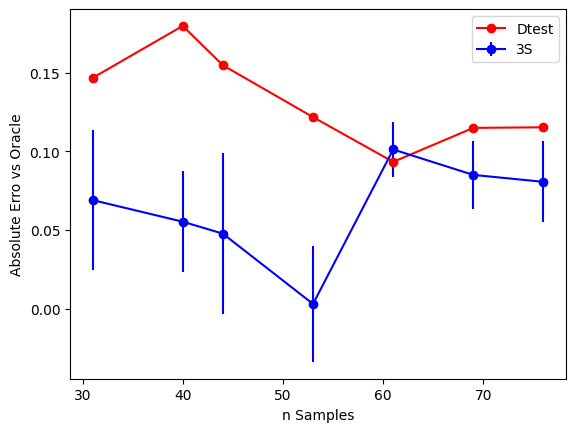

In [5]:
import matplotlib.pyplot as plt
def plot_comparison(dict_list, group=0):
    x = []
    y_mean10_vs_oracle = []
    y_test_vs_oracle = []
    yerr = []

    # Iterate through the list of dictionaries
    for data_dict in dict_list:
        # Since each dictionary contains only one key-value pair, we'll unpack them here
        for key, values in data_dict.items():
            mean10_value = values['mean10'][0]
            test_value = values['test'][0]
            oracle_value = values['oracle'][0]
            std10_value = values['std10'][0]
            
            samples = values['groupsize']


            mean_abs_error_mean10 = abs(oracle_value - mean10_value)
            mean_abs_error_test = abs(oracle_value - test_value)

            x.append(samples)
            y_mean10_vs_oracle.append(mean_abs_error_mean10)
            y_test_vs_oracle.append(mean_abs_error_test)
            yerr.append(std10_value)

    
    min_group_size = 0
    max_group_size = 0

    
    plt.errorbar(x, y_mean10_vs_oracle, yerr=yerr, marker='o', linestyle='-', color='blue', label='3S')
    plt.plot(x, y_test_vs_oracle, marker='o', linestyle='-', color='red', label='Dtest')
    plt.xlabel('n Samples')
    plt.ylabel('Absolute Error vs Oracle')
    plt.legend()
    plt.show()


plot_comparison([dict[0] for dict in res_loop], group=i)